In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import copy
import matplotlib.pyplot as plt

In [2]:
bars = np.loadtxt("bars", delimiter="\n", dtype=str)
bars_rc = np.array([ np.loadtxt("bars_rc", delimiter="\n", dtype=str).reshape(1)[0][i:i+8] for i in range(0, 96*8, 8) ][::-1])
#bars_rc = bars

In [3]:
# Subset barcodes for when we hadn't bought all barcodes (due to my code having a bug)

#selec = np.array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
#         17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 30, 39, 41, 45,
#         47, 49, 52, 55, 56, 59, 61, 65, 66 ]) - 1
#selec = np.array([79, 82, 84, 56, 59, 61, 65, 66, 68, 69, 70, 71,
#                  77, 25, 28, 30, 39, 41, 45, 47, 49, 52, 55
#                 ]
#                ) - 1
selec = np.arange(len(bars))
bars = bars[selec]
bars_rc = bars_rc[selec]

# Check for Rev. Complements

In [4]:
intersect = [value for value in bars_rc if value in bars] 
print('Reverse complement pairs:')
print('sequences:')
print(intersect)
print('Barcode numbers:')
tmp = np.array([(selec[np.where(bars == b)[0][0]]+1,
                 selec[np.where(bars_rc == b)[0][0]]+1)
                for b in intersect
               ]
              )
print(tmp)

Reverse complement pairs:
sequences:
['CTCTCTCT', 'GAATCTCG', 'ATCGGTCA', 'ACCGATTG', 'CGAGATTC', 'CAAGGTCT', 'TTCCTTCC', 'TCCCCTTT', 'AGACCTTG', 'GTCAATCG', 'GCCAGTTA', 'ATCTCGGA', 'ACCTTGAG', 'CGATTGAC', 'CAATCGGT', 'TTCGGGGC', 'TCCGAGAT', 'AGAGAGAG', 'AAAGGGGA', 'GTCCTGGG', 'GCCCCGAA', 'TGACCGAT', 'TAACTGGC', 'CTCAAGGT', 'CCCAGGAC', 'GGAAGGAA']
Barcode numbers:
[[66  5]
 [18  8]
 [82 14]
 [54 16]
 [ 8 18]
 [33 20]
 [96 28]
 [68 30]
 [20 33]
 [52 39]
 [84 41]
 [63 48]
 [92 50]
 [39 52]
 [16 54]
 [79 61]
 [48 63]
 [ 5 66]
 [30 68]
 [94 77]
 [61 79]
 [14 82]
 [41 84]
 [50 92]
 [77 94]
 [28 96]]


# Define distance metrics

In [5]:
import hashlib

def hamming_distance(chaine1, chaine2):
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))


import editdistance

def lcs(S,T):
    m = len(S)
    n = len(T)
    counter = [[0]*(n+1) for x in range(m+1)]
    longest = 0
    lcs_set = set()
    for i in range(m):
        for j in range(n):
            if S[i] == T[j]:
                c = counter[i][j] + 1
                counter[i+1][j+1] = c
                if c > longest:
                    lcs_set = set()
                    longest = c
                    lcs_set.add(S[i-c+1:i+1])
                elif c == longest:
                    lcs_set.add(S[i-c+1:i+1])

    return lcs_set

# Quantify similarity scores

In [6]:
# Calculate distance metrics on the reverse complement sequences
dist_ham_rc = np.zeros((len(bars),len(bars)))
dist_LD_rc = np.zeros((len(bars),len(bars)))
dist_ss_rc = np.zeros((len(bars),len(bars)))
for i, b in enumerate(bars):
    for j, b_rc in enumerate(bars_rc):
        dist_ham_rc[i,j] = hamming_distance(b, b_rc)
        dist_LD_rc[i,j] = editdistance.eval(b, b_rc)
        
        tmp = lcs(b, b_rc)
        if len(tmp) == 0:
            dist_ss_rc[i,j] = 8
        else:
            dist_ss_rc[i,j] = 8-len(lcs(b, b_rc).pop())

# Calculate distance metrics on the forward sequences
dist_ham = np.zeros((len(bars),len(bars)))
dist_LD = np.zeros((len(bars),len(bars)))
dist_ss = np.zeros((len(bars),len(bars)))
for i, b in enumerate(bars):
    for j, b_rc in enumerate(bars):
        dist_ham[i,j] = hamming_distance(b, b_rc)
        dist_LD[i,j] = editdistance.eval(b, b_rc)
        
        tmp = lcs(b, b_rc)
        if len(tmp) == 0:
            dist_ss[i,j] = 8
        else:
            dist_ss[i,j] = 8-len(lcs(b, b_rc).pop())

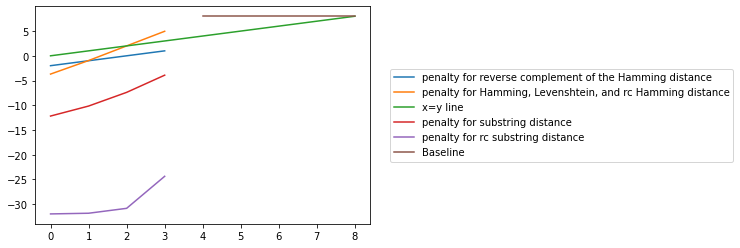

In [7]:
########################################################
## Decide penalty functions for the different metrics ##
########################################################

d1 = np.arange(0,4)
d2 = np.arange(4,9)
plt.plot(d1,d1-2, label = 'penalty for reverse complement of the Hamming distance')
plt.plot(d1, d1 + 16*((1/(1+np.exp(-0.5*(d1-2)))) - 0.5), label='penalty for Hamming, Levenshtein, and rc Hamming distance')
plt.plot(np.hstack((d1,d2)), np.hstack((d1,d2)), label = 'x=y line')
plt.plot(d1, 32*((1/(1+np.exp(-0.5*(d1-4)))) - 0.5), label = 'penalty for substring distance')
plt.plot(d1, 64*((1/(1+np.exp(-2*(d1-4)))) - 0.5), label = 'penalty for rc substring distance')
plt.plot(d2, [8]*len(d2), label = 'Baseline')
#plt.axvline(3.5);
plt.legend(loc='center right', bbox_to_anchor=(2.1, 0.5));

In [8]:
# Record scored minimal distances in a similarity matrix

# initialiase matrix with all barcodes being 8bp apart
sim_mat_quant = np.zeros((len(bars), len(bars))) + 8

# for all barcode pairs, record the minimum of the penalised distance functions, for distances less than 4
for d in range(3,-1,-1):
    
    tmp = pd.DataFrame(np.where(dist_ham==d)).T
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], d + 16*((1/(1+np.exp(-0.5*(d-2)))) - 0.5))
    
    tmp = pd.DataFrame(np.where(dist_ham_rc==d)).T
    #print(tmp)
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], d-2)
            #sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], 8*((1/(1+np.exp(-2*(d-3)))) - 0.5))
    
    tmp = pd.DataFrame(np.where(dist_LD==d)).T
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], d + 16*((1/(1+np.exp(-0.5*(d-2)))) - 0.5))
    
    tmp = pd.DataFrame(np.where(dist_LD_rc==d)).T
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], d + 16*((1/(1+np.exp(-0.5*(d-2)))) - 0.5))
    
    tmp = pd.DataFrame(np.where(dist_ss==d)).T
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            #sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], d-2)
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], 32*((1/(1+np.exp(-0.5*(d-4)))) - 0.5))

    tmp = pd.DataFrame(np.where(dist_ss_rc==d)).T
    for index, row in tmp.iterrows():
        if row[0] != row[1]:
            #sim_mat_quant[row[0], row[1]] = d-2
            sim_mat_quant[row[0], row[1]] = min(sim_mat_quant[row[0], row[1]], 64*((1/(1+np.exp(-2*(d-4)))) - 0.5))


In [9]:
# Iteratively remove the worst-scoring barcode in a greedy algorithm, until either all barcodes are removed, or all barcodes are perfectly apart

sub_sim_mat_quant = pd.DataFrame(copy.deepcopy(sim_mat_quant))

to_del = []
to_del_idx_list = "tmp"
while ((len(to_del_idx_list) != 0) and (len(to_del) != len(bars))):
    
    sums = np.sum(sub_sim_mat_quant.values, axis=0)
    to_del_idx_list = sub_sim_mat_quant.columns[np.where(sums == np.min(sums))[0]].values
    #print(to_del_idx_list)
    if len(to_del_idx_list) > 1:
        sums = []
        for idx in to_del_idx_list:
            tmp = copy.deepcopy(sub_sim_mat_quant)
            tmp.drop(idx, axis=0, inplace=True)
            tmp.drop(idx, axis=1, inplace=True)
            sums.append(np.sum(tmp.values))
        to_del_idx = to_del_idx_list[np.argmax(sums)]
    else:
        to_del_idx = to_del_idx_list[0]
    to_del.append(to_del_idx)
    #print(to_del)
    #i += 1
    #if i==2:
    #    break
    sub_sim_mat_quant.drop(to_del_idx, axis=0, inplace=True)
    sub_sim_mat_quant.drop(to_del_idx, axis=1, inplace=True)

In [10]:
print('Number of barcodes removed before perfect distances:')
print(len(to_del))

print('Barcodes removed in the following order:')
print(selec[np.array(to_del)] + 1)

Number of barcodes removed before perfect distances:
96
Barcodes removed in the following order:
[76 78 87 16 64 26 33 18 41 43 54 21 81 50 48  9 28 79 68 94 95 55 91 49
 29 34 17  1  4 72 83 63 75 19 36 70 13 59 66 38 39 82 27 10 84 57 44 20
 89 85 73 15 30 32  6 58 67 22  5 62 35 37 74 90 92  7 24 31 40 52 60  2
  3  8 11 12 14 23 25 42 45 46 47 51 53 56 61 65 69 71 77 80 86 88 93 96]


In [11]:
num_choose = 32

In [12]:
np.sort(selec[np.array(to_del[-num_choose:])] + 1)

array([ 2,  3,  7,  8, 11, 12, 14, 23, 24, 25, 31, 40, 42, 45, 46, 47, 51,
       52, 53, 56, 60, 61, 65, 69, 71, 77, 80, 86, 88, 92, 93, 96])

In [13]:
bars_sub = np.loadtxt("bars", delimiter="\n", dtype=str)[np.sort(selec[np.array(to_del[-num_choose:])])]
print(bars_sub)
bars_rc_sub = np.array([ np.loadtxt("bars_rc", delimiter="\n", dtype=str).reshape(1)[0][i:i+8] for i in range(0, 96*8, 8) ][::-1])[np.sort(selec[np.array(to_del[-num_choose:])])]

['CCACAATG' 'TGAGACCT' 'GAAAAGGG' 'CGAGATTC' 'TTAGCCAG' 'GGACCCCA'
 'TGACCGAT' 'AGAAGAGG' 'GTACGCAT' 'CGAAGCCC' 'TTACGGTG' 'ACAGTGCT'
 'CCAGTTAG' 'TGCTACAG' 'GCCGACCA' 'CACCACGG' 'AGCTAGTC' 'GTCAATCG'
 'CGCTATGA' 'CGCGCACA' 'TTCTCCTC' 'GCCCCGAA' 'GACACTAC' 'CTCGGAAT'
 'TCCAGAGT' 'CCCAGGAC' 'GGCCGGTT' 'GCCTTAGA' 'AGCATCAC' 'ACCTTGAG'
 'TACGTGCA' 'TTCCTTCC']


In [14]:
dist_ham_rc = np.zeros((len(bars_sub),len(bars_sub)))
dist_LD_rc = np.zeros((len(bars_sub),len(bars_sub)))
dist_ss_rc = np.zeros((len(bars_sub),len(bars_sub)))
for i, b in enumerate(bars_sub):
    for j, b_rc in enumerate(bars_rc_sub):
        dist_ham_rc[i,j] = hamming_distance(b, b_rc)
        dist_LD_rc[i,j] = editdistance.eval(b, b_rc)
        
        tmp = lcs(b, b_rc)
        if len(tmp) == 0:
            dist_ss_rc[i,j] = 8
        else:
            dist_ss_rc[i,j] = 8-len(lcs(b, b_rc).pop())

dist_ham = np.zeros((len(bars_sub),len(bars_sub)))
dist_LD = np.zeros((len(bars_sub),len(bars_sub)))
dist_ss = np.zeros((len(bars_sub),len(bars_sub)))
for i, b in enumerate(bars_sub):
    for j, b_rc in enumerate(bars_sub):
        dist_ham[i,j] = hamming_distance(b, b_rc)
        dist_LD[i,j] = editdistance.eval(b, b_rc)
        
        tmp = lcs(b, b_rc)
        if len(tmp) == 0:
            dist_ss[i,j] = 8
        else:
            dist_ss[i,j] = 8-len(lcs(b, b_rc).pop())

In [15]:
np.unique(np.triu(dist_ham_rc), return_counts=True)

(array([0., 4., 5., 6., 7., 8.]), array([496,  81,  60, 255,  60,  72]))

In [16]:
np.unique(np.triu(dist_LD_rc), return_counts=True)

(array([0., 3., 4., 5., 6., 7., 8.]),
 array([496,   5, 125, 140, 199,  39,  20]))

In [17]:
np.unique(np.triu(dist_ss_rc), return_counts=True)

(array([0., 4., 5., 6., 7., 8.]), array([496,  36, 115, 340,  31,   6]))

In [18]:
# This is to identify any zeros. Any zeros not caused by the tri-upper function should show up as 0 here
np.unique(np.triu(dist_ss_rc-0.5)+0.5, return_counts=True)

(array([0.5, 4. , 5. , 6. , 7. , 8. ]), array([496,  36, 115, 340,  31,   6]))

In [19]:
np.unique(np.triu(dist_ham), return_counts=True)

(array([0., 4., 5., 6., 7., 8.]), array([528,  87,  42, 294,  20,  53]))

In [20]:
np.unique(np.triu(dist_LD), return_counts=True)

(array([0., 3., 4., 5., 6., 7., 8.]),
 array([528,   4, 117, 154, 190,  24,   7]))

In [21]:
np.unique(np.triu(dist_ss), return_counts=True)

(array([0., 4., 5., 6., 7., 8.]), array([528,  47, 142, 281,  22,   4]))